## Stones2Milestones Assignment

**The code is well commented. Kindly read the # comments along with each cell. Most of the plots are interactive. Try poking around.**<br>
**Would love to clarify your issues and descrive the parts of the code myself, Feel free to call on: 9971045637**
**email: santakmohanty0000@gmail.com**

**Objective:** We try to obtain the following metrics-<br>
1. Sales conversion with respect to Trainers<br>
2. Sales conversion with respect to Time slot<br>
3. Sales conversion with respect to Topic<br>
4. Sales conversion with respect to Source (Field available in Interested Users)<br>
5. Sales conversion wrt grade<br>
6. Time taken for Sales conversion<br>
7. Time slot – attendance %<br>

**We start with a preliminary viz analysis and data sanity checks of the given datasets.**<br>
The Comments within the codelocks tell us more about the steps involved.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#loading the Datasets as seperate Dataframes:
interested_users=pd.read_excel("assignment_data.xlsx",sheet_name="Interested Users")
booked_user=pd.read_excel("assignment_data.xlsx",sheet_name="Booked Users")
trainers=pd.read_excel("assignment_data.xlsx",sheet_name="Trainers")
subscription_bought=pd.read_excel("assignment_data.xlsx",sheet_name="Subscription Bought")

In [1218]:
interested_users.info()

#**It seems the data is free of any null values,(except for 2 entries in 'source')**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 6 columns):
phone           1683 non-null int64
email_id        1683 non-null object
school          1683 non-null object
grade           1683 non-null object
source          1681 non-null object
Submitted At    1683 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 79.0+ KB


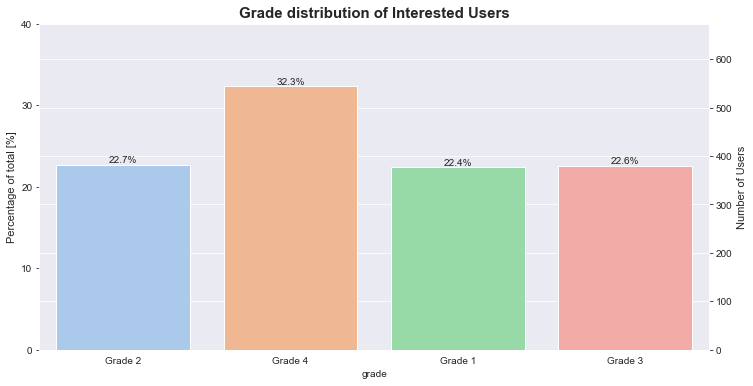

In [3]:
# Distribution of users by grade

import matplotlib.ticker as ticker

sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
ax=sns.countplot(interested_users['grade'], palette="pastel")

ax2=ax.twinx()
ax2.set_title("Grade distribution of Interested Users",fontweight="bold",fontsize=15)
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Percentage of total [%]',fontsize=11)
ax.set_ylabel('Number of Users',fontsize=11)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(interested_users['grade'])), (x.mean(), y), ha='center', va='bottom')
ax2.set_ylim(0,40)
ax.set_ylim(0,len(interested_users['grade'])/2.5)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.grid(False)

In [1220]:
booked_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 8 columns):
Batch             1711 non-null object
Enrolment Type    1711 non-null object
Grade             1711 non-null object
 School           1694 non-null object
Phone             1711 non-null int64
Parent Email      1711 non-null object
Booked Time       1711 non-null object
Attendance        1592 non-null object
dtypes: int64(1), object(7)
memory usage: 107.0+ KB


In [1221]:
booked_user.head()

,Batch,Enrolment Type,Grade,School,Phone,Parent Email,Booked Time,Attendance
0,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,DPS,911100222445,s2m_test_21459@tests2m.com,16-04-2020 11:15:00,Present
1,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,DPS,911100222446,s2m_test_21460@tests2m.com,16-04-2020 11:15:00,Present
2,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,City Montessori school lucknow,911100222447,s2m_test_21461@tests2m.com,16-04-2020 11:15:00,Absent
3,"fREADom Trial - Grades 3, 4 [I] 11:15am - Thu...",Trial,Grade 4,Reliance Foundation,911100222448,s2m_test_21462@tests2m.com,16-04-2020 11:15:00,Absent
4,"fREADom Trial - Grades 3, 4 [I] 11:15am - Thu...",Trial,Grade 3,KRS,911100222449,s2m_test_21463@tests2m.com,16-04-2020 11:15:00,Present


In [1222]:
# Checking the type
type(booked_user['Booked Time'][0])

str

In [4]:
from datetime import datetime
booked_user["Booked Time"]=booked_user["Booked Time"].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M:%S'))

In [5]:
booked_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 8 columns):
Batch             1711 non-null object
Enrolment Type    1711 non-null object
Grade             1711 non-null object
 School           1694 non-null object
Phone             1711 non-null int64
Parent Email      1711 non-null object
Booked Time       1711 non-null datetime64[ns]
Attendance        1592 non-null object
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 107.0+ KB


### Q7. Time slot – attendance %

From the looks of it, we can feature engineer the timeslot from the 'Batch' information and categorize the present and absent information based on it.<br> 
**NOTE:**<br>
From a visual analysis of the data we can see that, the 'Booked Time' is always same as the time in 'Batch' column of the students, essentially meaning all the students booked the classes immidiately before joining, and then there are some entries who booked the class immidiately and then were absent from the same class.<br>
This raises some doubts about the column 'Booked Time', and what exactly is it recording. On a safe side we opt to extract the informantion from the batch details.<br>

**PS:** We are doing this question first as this is pretty straightforward and can be done using this dataset only. Also we will be using the derrived outcomes later for other questions.

In [6]:
# Adding a column Named Time Slot, extracted from the Btach Column:
# Note: from above we know that there are no Missing values in this column, hence no cleanup required.
def get_time_slot(batch):
    loc=batch.find('am')
    if loc!=-1:
        ts= batch[loc-5:loc]
        return (ts+" "+"AM")
    else:
        loc=batch.find('pm')
        ts= batch[loc-5:loc]
        return (ts+" "+"PM")

In [7]:
booked_user['Time Slot']=booked_user['Batch'].apply(get_time_slot)
booked_user.head()

# Notice the added 'Time Slot' Column

,Batch,Enrolment Type,Grade,School,Phone,Parent Email,Booked Time,Attendance,Time Slot
0,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,DPS,911100222445,s2m_test_21459@tests2m.com,2020-04-16 11:15:00,Present,11:15 AM
1,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,DPS,911100222446,s2m_test_21460@tests2m.com,2020-04-16 11:15:00,Present,11:15 AM
2,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,City Montessori school lucknow,911100222447,s2m_test_21461@tests2m.com,2020-04-16 11:15:00,Absent,11:15 AM
3,"fREADom Trial - Grades 3, 4 [I] 11:15am - Thu...",Trial,Grade 4,Reliance Foundation,911100222448,s2m_test_21462@tests2m.com,2020-04-16 11:15:00,Absent,11:15 AM
4,"fREADom Trial - Grades 3, 4 [I] 11:15am - Thu...",Trial,Grade 3,KRS,911100222449,s2m_test_21463@tests2m.com,2020-04-16 11:15:00,Present,11:15 AM


In [8]:
print(booked_user['Time Slot'].value_counts().sum())
booked_user['Time Slot'].value_counts()

# We can see that we have successfully extracted the 'Time Slot' info for all the entries (1711) in the dataset.

1711


06:00 PM    534
11:45 AM    498
04:00 PM    243
06:15 PM    235
11:15 AM    201
Name: Time Slot, dtype: int64

In [9]:
# Let us take a look at the attendance column:

booked_user['Attendance'].value_counts()

# It seems we might need some cleanup: Identify and merge the variations in entries. 

Present                             872
Absent                              577
Cancelled                            88
Present                              13
Absent                               11
absent                                9
present                               8
Attended                              5
Preset                                1
Duplicate                             1
Presnt                                1
REPEAT NAME                           1
Present with video and audio off      1
:Present                              1
Present (Grade 8)                     1
Attended                              1
Present logged in and out             1
Name: Attendance, dtype: int64

In [10]:
# We merge the duplicates of Present and Absent, fix the typos.
# Assuming "Cancelled","Present with video and audio off", "Present logged in and out",... 
# ..."Duplicate", "REPEAT NAME" as Absent. 
# Fixing the errors manually. 

booked_user.loc[booked_user['Attendance']==("Present"), 'Attendance']="Present"
booked_user.loc[booked_user['Attendance']==("Present "), 'Attendance']="Present"
booked_user.loc[booked_user['Attendance']==("present"), 'Attendance']="Present"
booked_user.loc[booked_user['Attendance']==("Attended"), 'Attendance']="Present"
booked_user.loc[booked_user['Attendance']==("Attended "), 'Attendance']="Present"
booked_user.loc[booked_user['Attendance']==(":Present"), 'Attendance']="Present"
booked_user.loc[booked_user['Attendance']==("Preset"), 'Attendance']="Present"
booked_user.loc[booked_user['Attendance']==("Presnt"), 'Attendance']="Present"
booked_user.loc[booked_user['Attendance']==("Present logged in and out"), 'Attendance']="Present"
booked_user.loc[booked_user['Attendance']==("Present (Grade 8)"), 'Attendance']="Present"

booked_user.loc[booked_user['Attendance']==("Absent"), 'Attendance']="Absent"
booked_user.loc[booked_user['Attendance']==("Cancelled"), 'Attendance']="Absent"
booked_user.loc[booked_user['Attendance']==("Absent "), 'Attendance']="Absent"
booked_user.loc[booked_user['Attendance']==("absent"), 'Attendance']="Absent"
booked_user.loc[booked_user['Attendance']==("Present with video and audio off"), 'Attendance']="Absent"
booked_user.loc[booked_user['Attendance']==("Duplicate"), 'Attendance']="Absent"
booked_user.loc[booked_user['Attendance']==("REPEAT NAME"), 'Attendance']="Absent"

In [11]:
#sns.set()
#booked_user[['Time Slot','Attendance']].set_index('Attendance').T.plot(kind='bar', stacked=True)

atte_freq=pd.DataFrame(index=booked_user['Time Slot'].unique(), columns=['Present','Absent'])

for t in booked_user['Time Slot'].unique():
    pf=booked_user[booked_user['Time Slot']== t][booked_user['Attendance']=="Present"]['Attendance'].count()
    atte_freq.loc[t,'Present']=pf
    af=booked_user[booked_user['Time Slot']== t][booked_user['Attendance']=="Absent"]['Attendance'].count()
    atte_freq.loc[t,'Absent']=af

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [12]:
#atte_freq['Total']=atte_freq['Present']+atte_freq['Absent']
#atte_freq.reset_index(inplace=True)
atte_freq['Present Percentage (%)']=round(((atte_freq['Present']/(atte_freq['Present']+atte_freq['Absent']))*100), 2)
atte_freq['Absent Percentage (%)']=round(((atte_freq['Absent']/(atte_freq['Present']+atte_freq['Absent']))*100), 2)
atte_freq

,Present,Absent,Present Percentage (%),Absent Percentage (%)
11:15 AM,113,70,61.75,38.25
04:00 PM,155,85,64.58,35.42
06:15 PM,152,78,66.09,33.91
11:45 AM,235,232,50.32,49.68
06:00 PM,249,223,52.75,47.25


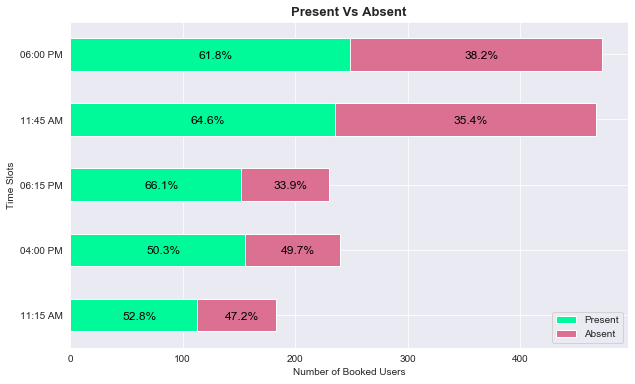

In [13]:
# Plotting the above data for better representation

ax= atte_freq[['Present','Absent']].plot(kind='barh',stacked=True,figsize=(10,6),color=['mediumspringgreen','palevioletred'])
ax.set_title("Present Vs Absent",fontweight='bold',fontsize=13)
ax.set_xlabel("Number of Booked Users")
ax.set_ylabel("Time Slots")
# Set txt
kx = -10.1
ky = -.06

values = []
for key in atte_freq[['Present Percentage (%)']].values:
    values = values + list(key)
values=list(reversed(values))

values2=[]
for key in atte_freq[['Absent Percentage (%)']].values:
    values2 = values2 + list(key)
values2=list(reversed(values2))

values=values+values2

for i,rec in enumerate(ax.patches):
    ax.text(rec.get_xy()[0]+rec.get_width()/2+kx,rec.get_xy()[1]+rec.get_height()/2+ky,'{:.1%}'.format(values[i]/100), fontsize=12, color='black')

**This is the desired answer for the Q7.**

In [14]:
# Plotting an interactive chart to see the grade wise distribution of the Booked Users 
#(Hover on the bars and use the toolkit on the top right of the figure)

import plotly as py
import cufflinks as cf
from plotly .offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()
from bokeh.palettes import viridis

fig=booked_user['Grade'].value_counts().iplot(kind='bar',barmode='stack',asFigure = False, color="#00CC96")

# We see that this is consistent with the distribution we found in the above chart. 

In [1234]:
trainers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 6 columns):
Trainer Name    173 non-null object
Date            174 non-null object
Timing          174 non-null object
Grade           174 non-null object
Batch           174 non-null object
Topics          174 non-null object
dtypes: object(6)
memory usage: 8.2+ KB


In [1235]:
trainers['Trainer Name'].value_counts().count()

49

In [1236]:
subscription_bought.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 8 columns):
Registered Number       409 non-null float64
Registered Email ID     391 non-null object
Payment date            412 non-null object
Sale by                 252 non-null object
Grade                   394 non-null object
Pricing                 412 non-null int64
Sessions preferred      233 non-null object
Live session details    214 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 25.8+ KB


**The data above seems all over the place, Lets take a look at the extent of missing values:**

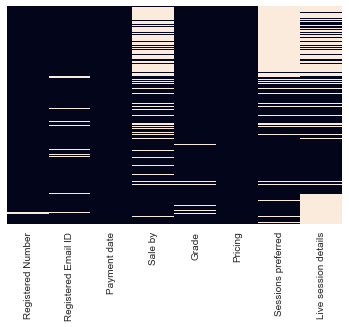

In [1237]:
sns.heatmap(subscription_bought.isnull(), yticklabels=False,cbar=False)

**The Light coloured strokes above represent missing values:**<br>
considering the small size of the dataset (412 datapoints) the columns 'sale by', 'Sessions preffered', and 'Live session details' seems unuasable owing to the large number of missing values. Also they seem less relevant for the given objective. 

### Q1. Sales Conversion with respect to trainers.

**Steps Involved:**
- We pick the registered number for all the sales above 499 the 'Subscription Bought' sheet.
- Now we look up the numbers in the 'Booked Users' sheet and find the attended batch information.
- Using the batch information we find the correponding trainer form the 'Trainers' Sheet.
- Record the sale number and amount against each trainer.

In [16]:
subscribed=subscription_bought[subscription_bought['Pricing']>499][['Registered Number','Registered Email ID','Pricing','Payment date']]
subscribed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270 entries, 12 to 411
Data columns (total 4 columns):
Registered Number      267 non-null float64
Registered Email ID    250 non-null object
Pricing                270 non-null int64
Payment date           270 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 10.5+ KB


**Now we need to locate the right tutor form the Trainers dataset**

We need 3 important information to pinpoint the tutor: 
- Trial, 
- Date & Time, 
- Grade

**Now we need to make some changes to the 'Trainers' dataset before we can extract the correct turor:**<br>
Mostly cleaning the data and trying to match the formats so that the join operation can read the data properly.

In [17]:
trainers['Timing'].value_counts()
# Need to fix the impurities and Match our Time Slots format from earlier

6.00 pm - 6.45 pm     55
11.45 am -12.30 pm    53
6:15 - 7:00 pm        24
4:00-4:45 pm          20
11.15 am - 12 noon    20
4.00-4.45 pm           2
Name: Timing, dtype: int64

In [18]:
trainers.loc[trainers['Timing']=="4.00-4.45 pm", 'Timing']="04:00 PM"
trainers.loc[trainers['Timing']=="11.15 am - 12 noon", 'Timing']="11:15 AM"
trainers.loc[trainers['Timing']=="4:00-4:45 pm", 'Timing']="04:00 PM"
trainers.loc[trainers['Timing']=="6:15 - 7:00 pm", 'Timing']="06:15 PM"
trainers.loc[trainers['Timing']=="11.45 am -12.30 pm", 'Timing']="11:45 AM"
trainers.loc[trainers['Timing']=="6.00 pm - 6.45 pm ", 'Timing']="06:00 PM"

In [19]:
trainers['Timing'].value_counts()

06:00 PM    55
11:45 AM    53
06:15 PM    24
04:00 PM    22
11:15 AM    20
Name: Timing, dtype: int64

In [20]:
# Looking at the Date column in the Trainers dataset: 
# We dont exactly need the day of the week information.
# Extracting the day and the month and converting it into date time wil be useful.

In [21]:
def to_date(date):
    nd=""
    for w in date.split()[0:2]:
        nd=nd+w+" "
    nd=nd+"2020"
    return nd

In [22]:
trainers['Date']=trainers['Date'].apply(to_date)
trainers['Date']=trainers['Date'].apply(lambda x: datetime.strptime(x, '%d %B %Y'))

In [40]:
trainers['Batch']=trainers['Batch'].apply(lambda x: x.lower())

In [47]:
trainers.loc[trainers['Grade']=="Grade 1,2", 'Grade']="Grades 1,2"
trainers.loc[trainers['Grade']=="Grade 3,4", 'Grade']="Grades 3,4"
trainers.loc[trainers['Grade']=="Grade 1,2 ", 'Grade']="Grades 1,2"
trainers.loc[trainers['Grade']=="Grade 3,4 ", 'Grade']="Grades 3,4"

In [41]:
trainers.head()

,Trainer Name,Date,Timing,Grade,Batch,Topics
0,FAC_5001,2020-04-16,11:15 AM,"Grade 1,2",trial i,Rocking with rhymes
1,FAC_5002,2020-04-16,11:15 AM,"Grade 3,4",trial i,In my mind's eye
2,FAC_5003,2020-04-16,11:15 AM,"Grade 1,2",trial ii,Word Whiz
3,FAC_5006,2020-04-16,11:15 AM,"Grade 3,4",trial ii,Rocking with rhymes
4,FAC_5007,2020-04-16,04:00 PM,"Grade 3,4",trial i,In my head or real


**NOTE:** We are trying to find the sales conversion, which essentially is the ratio number of students who subscribed  among those who attended a tutor's class.<br>
We can do this by adding the tutor column in the all the Booked User dataset. 

In [23]:
booked_user.head()

# We need to extract the trial number, Grade category, and date-time then Trainer.

,Batch,Enrolment Type,Grade,School,Phone,Parent Email,Booked Time,Attendance,Time Slot
0,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,DPS,911100222445,s2m_test_21459@tests2m.com,2020-04-16 11:15:00,Present,11:15 AM
1,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,DPS,911100222446,s2m_test_21460@tests2m.com,2020-04-16 11:15:00,Present,11:15 AM
2,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,City Montessori school lucknow,911100222447,s2m_test_21461@tests2m.com,2020-04-16 11:15:00,Absent,11:15 AM
3,"fREADom Trial - Grades 3, 4 [I] 11:15am - Thu...",Trial,Grade 4,Reliance Foundation,911100222448,s2m_test_21462@tests2m.com,2020-04-16 11:15:00,Absent,11:15 AM
4,"fREADom Trial - Grades 3, 4 [I] 11:15am - Thu...",Trial,Grade 3,KRS,911100222449,s2m_test_21463@tests2m.com,2020-04-16 11:15:00,Present,11:15 AM


In [24]:
# Going for the oldest hack in the book: copy-paste!

# Extract Trial
def trail(batch):
    trail=batch[batch.find('[')+1:batch.find(']')]
    return trail
booked_user['Trial number']=booked_user['Batch'].apply(trail)

booked_user['Trial number']=booked_user['Trial number'].apply(lambda x: "trial "+x)
booked_user['Trial number']=booked_user['Trial number'].apply(lambda x: x.lower())
booked_user['Trial number']=booked_user['Trial number'].apply(lambda x: x.strip())

In [25]:
# Extract Grade
def grade(batch):
    grade=batch[batch.find('Grades')-1+1:batch.find('Grades')+11]
    return grade

booked_user['Grade category']=booked_user['Batch'].apply(grade)

In [26]:
booked_user.loc[booked_user['Grade category']=="Grades 3, 4", 'Grade category']="Grades 3,4"
booked_user.loc[booked_user['Grade category']=="Grades 1, 2", 'Grade category']="Grades 1,2"
booked_user.loc[booked_user['Grade category']=="Grades 1,2 ", 'Grade category']="Grades 1,2"

In [44]:
booked_user['Grade category'].head()

0    Grades 1,2
1    Grades 1,2
2    Grades 1,2
3    Grades 3,4
4    Grades 3,4
Name: Grade category, dtype: object

In [43]:
trainers['Grade'].head()

0     Grade 1,2
1    Grade 3,4 
2     Grade 1,2
3    Grade 3,4 
4    Grade 3,4 
Name: Grade, dtype: object

**Here we do the actual extraction of tutor names**<br>
We comapre 4 values:
- Date
- Time
- Trial Number/Batch
- Grade Category/Grade

In [49]:
trainer=[]
topic=[]
for i in range(0,len(booked_user)):
    dt=booked_user.iloc[i]['Booked Time'].date()
    ts=booked_user.iloc[i]['Time Slot']
    tn=booked_user.iloc[i]['Trial number']
    gr=booked_user.iloc[i]['Grade category']
    j=0
    for j in range(0,len(trainers)):
        if trainers.iloc[j]['Date'].date()==dt:
            if trainers.iloc[j]['Timing']==ts:
                if trainers.iloc[j]['Batch']==tn:
                    if (trainers.iloc[j]['Grade']==gr):
                        trainer.append(trainers.iloc[j]['Trainer Name'])
                        topic.append(trainers.iloc[j]['Topics'])


# prob:heavy; [[[""][""","""]]] method more intensive.
# L/U_test: G4 non-branching design: too many layers!

In [52]:
column_values = pd.Series(trainer)
booked_user.insert(loc=0, column='Trainer', value=column_values)
booked_user.insert(loc=0, column='Topic', value=pd.Series(topic))

In [53]:
booked_user.head()
#successfully added the Trainer column.

,Topic,Trainer,Batch,Enrolment Type,Grade,School,Phone,Parent Email,Booked Time,Attendance,Time Slot,Trial number,Grade category
0,Rocking with rhymes,FAC_5001,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,DPS,911100222445,s2m_test_21459@tests2m.com,2020-04-16 11:15:00,Present,11:15 AM,trial i,"Grades 1,2"
1,Rocking with rhymes,FAC_5001,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,DPS,911100222446,s2m_test_21460@tests2m.com,2020-04-16 11:15:00,Present,11:15 AM,trial i,"Grades 1,2"
2,Rocking with rhymes,FAC_5001,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,Grade 2,City Montessori school lucknow,911100222447,s2m_test_21461@tests2m.com,2020-04-16 11:15:00,Absent,11:15 AM,trial i,"Grades 1,2"
3,In my mind's eye,FAC_5002,"fREADom Trial - Grades 3, 4 [I] 11:15am - Thu...",Trial,Grade 4,Reliance Foundation,911100222448,s2m_test_21462@tests2m.com,2020-04-16 11:15:00,Absent,11:15 AM,trial i,"Grades 3,4"
4,In my mind's eye,FAC_5002,"fREADom Trial - Grades 3, 4 [I] 11:15am - Thu...",Trial,Grade 3,KRS,911100222449,s2m_test_21463@tests2m.com,2020-04-16 11:15:00,Present,11:15 AM,trial i,"Grades 3,4"


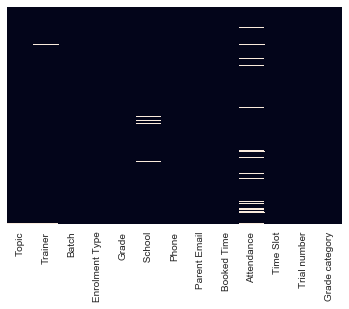

In [54]:
# Checking completeness

sns.heatmap(booked_user.isnull(),cbar=False,yticklabels=False)

# Looks Good!

In [56]:
## The following is a sorted list of number of students that were 'Present' in a class with the respective faculties
trainer_student_count=booked_user[booked_user['Attendance']=="Present"].groupby('Trainer').count()['Batch'].sort_values()
trainer_student_count.head()

Trainer
FAC_5047    2
FAC_5051    2
FAC_5044    4
FAC_5030    4
FAC_5001    5
Name: Batch, dtype: int64

In [57]:
subscribed.head()

,Registered Number,Registered Email ID,Pricing,Payment date
12,9.111002e+11,s2m_test_21900@tests2m.com,999,18-03-2020 12:00:00 AM
15,9.111002e+11,s2m_test_21903@tests2m.com,1999,18-03-2020 12:00:00 AM
23,9.111002e+11,s2m_test_21911@tests2m.com,1999,19-03-2020 12:00:00 AM
27,9.111002e+11,s2m_test_21915@tests2m.com,1999,19-03-2020 12:00:00 AM
31,9.111002e+11,s2m_test_21919@tests2m.com,999,20-03-2020 12:00:00 AM


In [58]:
# trying to extract batch info from Booked Users on the basis of Number and email.
# then we merge both and remove the duplicates: We do this to avoid droppin of either missing row or column...
# Direct merge will drop the entries with missing values either phone or email, we will see this later in Q4


ph = pd.merge(subscribed, booked_user[['Phone','Batch','Booked Time', 'Time Slot','Grade','Trial number','Trainer','Topic']],\
              left_on='Registered Number',right_on='Phone',how='inner',suffixes=('_left','_right'))
em = pd.merge(subscribed, booked_user[['Parent Email','Batch','Booked Time','Time Slot','Grade','Trial number','Trainer','Topic']],\
              left_on='Registered Email ID',right_on='Parent Email',how='inner',suffixes=('_left','_right'))

In [59]:
booked_subscribed=pd.concat([ph,em], ignore_index=True, sort=True)
booked_subscribed.drop_duplicates(subset='Registered Email ID', keep='first',inplace=True)

In [60]:
booked_subscribed.drop('Phone',axis=1,inplace=True)
booked_subscribed.drop('Parent Email',axis=1, inplace=True)
booked_subscribed.drop('Batch',axis=1,inplace=True)

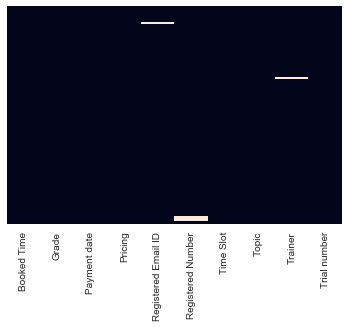

In [61]:
sns.heatmap(booked_subscribed.isnull(),cbar=False,yticklabels=False)
# Looks like we are missing 2 phone, one email, and one trainer information; Shouldn't be a problem as of now. 

In [1129]:
booked_subscribed.head()

,Booked Time,Grade,Payment date,Pricing,Registered Email ID,Registered Number,Time Slot,Topic,Trainer,Trial number
0,2020-04-16 18:15:00,"Grades 3,4",26-03-2020 12:00:00 AM,1999,s2m_test_21964@tests2m.com,9.111002e+11,06:15 PM,In my head or real,FAC_5015,trial ii
1,2020-04-24 11:45:00,"Grades 1,2",2020-04-04 13:26:05,1999,s2m_test_21807@tests2m.com,9.111002e+11,11:45 AM,Elements of a story,FAC_5011,trial i
3,2020-04-16 11:15:00,"Grades 3,4",2020-06-04 23:22:12,999,s2m_test_21486@tests2m.com,9.111002e+11,11:15 AM,Rocking with rhymes,FAC_5006,trial ii
4,2020-04-21 11:45:00,"Grades 3,4",2020-08-04 16:44:32,1999,s2m_test_21753@tests2m.com,9.111002e+11,11:45 AM,Storm in my brain,FAC_5015,trial i
5,2020-04-18 16:00:00,"Grades 1,2",2020-11-04 16:56:01,999,s2m_test_21682@tests2m.com,9.111002e+11,04:00 PM,Sum it up,FAC_5009,trial iii


**This above is a list of all the subscribed students(above 499) who booked a class along with the necessary details**

In [83]:
# This is a list of number of subscribed students who took a class with the respective Faculty.
trainer_subscribed_count=booked_subscribed.groupby('Trainer').count()['Grade'].sort_values()

In [84]:
# Lets represent the data in a good format

trainer_performance=pd.concat([trainer_subscribed_count,trainer_student_count], axis=1,sort=True).reset_index()

In [85]:
# Dropping the trainers with no subscribed user: assuming we don't have data on them instead of zero subscribed students.
# Fixing column names
trainer_performance.dropna(inplace=True)
trainer_performance.rename(columns={'index':'Trainer Name','Grade':'No. of students subscribed',\
                                    'Batch':'No. of students attended'}, inplace=True)
trainer_performance['No. of students subscribed']=trainer_performance['No. of students subscribed'].astype(int)
trainer_performance.dropna(inplace=True)

In [86]:
trainer_performance.head()

,Trainer Name,No. of students subscribed,No. of students attended
1,FAC_5002,4,68
2,FAC_5003,3,11
4,FAC_5006,5,31
5,FAC_5007,1,9
6,FAC_5008,5,57


In [87]:
trainer_performance['Sale Conversion [%]']=round((trainer_performance['No. of students subscribed']/ \
                                            trainer_performance['No. of students attended'])*100,2)

In [963]:
trainers['Trainer Name'].value_counts().count()
# We have info on 49 Trainers from the Trainers sheet

49

In [88]:
# Out of which there are 45 who had atleast one student who attended their class
booked_user['Trainer'].value_counts().count()

45

In [89]:
booked_subscribed['Trainer'].value_counts().count()
# Among the 45 we have 33 Trainers with atleast one sunscribed student

33

In [90]:
import plotly.express as px

px.bar(trainer_performance,x='Trainer Name', y='Sale Conversion [%]',color='Sale Conversion [%]',\
       color_continuous_scale='darkmint', title='Sale Conversion by Trainers')

**This should suffice the first question: Sale conversion by trainers**

### Q2. Sales conversion with respect to Time slot

In [1123]:
# Using similar steps as we used before.

In [91]:
# Using the time slot by type
booked_user[booked_user['Attendance']=='Present'].groupby('Time Slot').count()['Batch']

Time Slot
04:00 PM    155
06:00 PM    249
06:15 PM    152
11:15 AM    113
11:45 AM    235
Name: Batch, dtype: int64

In [92]:
Time_slot_performance=pd.concat([booked_subscribed.groupby('Time Slot').count()['Grade'], \
                                 booked_user[booked_user['Attendance']=='Present']['Time Slot'].value_counts()], \
                                axis=1,sort=False).reset_index()

In [1153]:
Time_slot_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
index        5 non-null object
Grade        5 non-null int64
Time Slot    5 non-null int64
dtypes: int64(2), object(1)
memory usage: 200.0+ bytes


In [93]:
Time_slot_performance.rename(columns={'index':'Time Slot','Grade':'No. of students subscribed',\
                                    'Time Slot':'No. of students attended'}, inplace=True)
#Time_slot_performance['No. of students attended']=Time_slot_performance['No. of students attended'].astype(int)

In [94]:
Time_slot_performance['Sale Conversion [%]']=round((Time_slot_performance['No. of students subscribed']/ \
                                            Time_slot_performance['No. of students attended'])*100,2)

In [1156]:
Time_slot_performance.head()

,Time Slot,No. of students subscribed,No. of students attended,Sale Conversion [%]
0,04:00 PM,12,155,7.74
1,06:00 PM,21,249,8.43
2,06:15 PM,17,152,11.18
3,11:15 AM,14,113,12.39
4,11:45 AM,19,235,8.09


In [1164]:
px.bar(Time_slot_performance,x='Time Slot', y='Sale Conversion [%]',color='Time Slot',\
       title='Sale Conversion in by Time Slot')

### Q2. Sales conversion with respect to Topic

In [95]:
#booked_user[booked_user['Attendance']=='Present'].groupby('Time Slot').count()['Batch']

Topic_performance=pd.concat([booked_subscribed['Topic'].value_counts(), \
                                 booked_user[booked_user['Attendance']=='Present']['Topic'].value_counts()], \
                                axis=1,sort=False).reset_index()

Topic_performance.head()

,index,Topic,Topic
0,Word Whiz,11.0,139
1,Name it,7.0,82
2,In my mind's eye,7.0,94
3,Rocking with rhymes,6.0,59
4,Structure of a story,5.0,61


In [96]:
# Dropping the Topics which had zero subscribed users; 
# Again, this is beacuse running with the assumption that we have insufficient data.

Topic_performance.columns = ['Topic', 'No. of students subscribed','No. of students attended']
Topic_performance.dropna(inplace=True)
Topic_performance['No. of students subscribed']=Topic_performance['No. of students subscribed'].astype(int)

In [1163]:
Topic_performance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 22
Data columns (total 3 columns):
Topic                         23 non-null object
No. of students subscribed    23 non-null int64
No. of students attended      23 non-null int64
dtypes: int64(2), object(1)
memory usage: 736.0+ bytes


In [97]:
Topic_performance['Sale Conversion [%]']=round((Topic_performance['No. of students subscribed']/ \
                                            Topic_performance['No. of students attended'])*100,2)

In [1170]:
px.bar(Topic_performance,x='Topic', y='Sale Conversion [%]',color='Topic',\
       title='Sale Conversion by Topic')

### Q4. Sales conversion with respect to Source.

**To start this we need to add the source column from the Interested users dataset**<br>
can use the phone or email column to do this<br>
**Note:** We need to go back to the full set, which had all the users who had subscribed above 499.

In [1173]:
subscribed.head()

,Registered Number,Registered Email ID,Pricing,Payment date
12,9.111002e+11,s2m_test_21900@tests2m.com,999,18-03-2020 12:00:00 AM
15,9.111002e+11,s2m_test_21903@tests2m.com,1999,18-03-2020 12:00:00 AM
23,9.111002e+11,s2m_test_21911@tests2m.com,1999,19-03-2020 12:00:00 AM
27,9.111002e+11,s2m_test_21915@tests2m.com,1999,19-03-2020 12:00:00 AM
31,9.111002e+11,s2m_test_21919@tests2m.com,999,20-03-2020 12:00:00 AM


In [123]:
subscribed_source=pd.merge(subscribed,interested_users[['phone','source','email_id']],\
                           left_on=['Registered Number','Registered Email ID'], right_on=['phone','email_id'],\
                           how='inner')

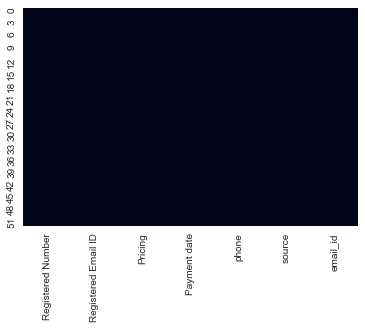

In [124]:
sns.heatmap(subscribed_source.isnull(),cbar=False)

# Notice the difference between the method in Q1 merge, we have dropped one entry with missing Phone by this method.

In [125]:
subscribed_source['source'].value_counts()

rfmsms        11
TEB5SMS        8
b1rmsms        5
ntfpush        5
TEB3SMS        5
T1KRMSMS       4
TEB4SMS        4
ntfuiuser      3
lastchance     2
TEB11SMS       2
adarsh         1
b2rmsms        1
TEB12SMS       1
b3rmsms        1
Name: source, dtype: int64

In [132]:
interested_users['source'].value_counts()

TEB5SMS           202
TEB3SMS           190
b1rmsms           163
rfmsms            160
TEB11SMS          124
TEB4SMS           117
b2rmsms           114
TEB2ASMS          113
ntfuiuser          80
b3rmsms            79
TEB12SMS           73
aprilhiusersms     63
T1KRMSMS           54
ntfpush            39
lastchance         37
TEB2BSMS           27
marchhiusms        18
nlusms             12
support             7
hiuserpush          3
adarsh              3
hiusersms           2
ot                  1
Name: source, dtype: int64

In [128]:
Source_performance=pd.concat([subscribed_source['source'].value_counts(), \
                                 interested_users['source'].value_counts()], \
                                axis=1,sort=False).reset_index()

In [130]:
Source_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
index     23 non-null object
source    14 non-null float64
source    23 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 632.0+ bytes


In [133]:
# Again we can see that we had 23 sources in interested users while only 14 in subscribed users,...
# we drop the sources with zero subscribed users for the same reason we mentioned above. 

Source_performance.columns = ['Source', 'No. of students subscribed','No. of students interested']
Source_performance.dropna(inplace=True)
Source_performance['No. of students subscribed']=Source_performance['No. of students subscribed'].astype(int)
Source_performance['Sale Conversion [%]']=round((Source_performance['No. of students subscribed']/ \
                                            Source_performance['No. of students interested'])*100,2)

In [135]:
px.bar(Source_performance,x='Source', y='Sale Conversion [%]',color='Source',\
       title='Sale Conversion by Source')

From above we can see that the results are skewed: One source has unusually high performance.<br>
From the above data we can attribute the analysis to the low number of leads in the interested user dataset.<br>
To avoid such situation we usualy apply some sort of lower cut-off, i.e one source needs to have 10 (let's say) leads to be considered.<br> ( A more extensive and accurate way would be to calculate it's median and then trim the outliers/edges)<br>
Here we can click on the legend on the right to get a glimpse of the same. 

### Q5. Sales conversion with respect to Grade.

In [137]:
booked_subscribed['Grade'].value_counts()

Grade 4    25
Grade 3    23
Grade 2    20
Grade 1    15
Name: Grade, dtype: int64

In [138]:
booked_user['Grade'].value_counts()

Grade 4      513
Grade 2      397
Grade 1      396
Grade 3      374
Grade 5       14
Junior KG     11
Senior KG      6
Name: Grade, dtype: int64

In [141]:
Grade_performance=pd.concat([booked_subscribed['Grade'].value_counts(), \
                                 booked_user['Grade'].value_counts()], \
                                axis=1,sort=False).reset_index()
Grade_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
index    7 non-null object
Grade    4 non-null float64
Grade    7 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 248.0+ bytes


In [143]:
Grade_performance.columns = ['Grade', 'No. of students subscribed','No. of students Booked']
Grade_performance.dropna(inplace=True)
Grade_performance['No. of students subscribed']=Grade_performance['No. of students subscribed'].astype(int)
Grade_performance['Sale Conversion [%]']=round((Grade_performance['No. of students subscribed']/ \
                                            Grade_performance['No. of students Booked'])*100,2)

In [145]:
px.bar(Grade_performance,x='Grade', y='Sale Conversion [%]',color='Grade',\
       title='Sale Conversion by Grade')

**Inference:** A poor metric.<br> Seems like Data too less. Variation seen in this limited data is not good enough derive meaningful insight. 

### Q6. Time taken for Sales conversion

In [146]:
#we are assuming this refers to the median time between attended class and the subscription payment.

In [154]:
booked_subscribed.info()

# Need to convert the payment colulmn into datetime datatype.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 0 to 173
Data columns (total 10 columns):
Booked Time            83 non-null datetime64[ns]
Grade                  83 non-null object
Payment date           83 non-null object
Pricing                83 non-null int64
Registered Email ID    82 non-null object
Registered Number      81 non-null float64
Time Slot              83 non-null object
Topic                  83 non-null object
Trainer                82 non-null object
Trial number           83 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 7.1+ KB


In [ ]:
# From a few errors we realized that the format of 'Payment Date' is not consistent.
# Usually this issue is much easier to fix this in Excel, but here the formats are way messed up for excel to realize.
# some dates like:    2020-04-04 13:26:05    2020-06-04 23:22:12    2020-08-04 16:44:32 are most probably in...
# YYYY-DD-MM, but for the machine it is impossibe to differentiate between this and the YYYY-MM-DD format, as the...
# month less than 12 error will not be raised. 

In [184]:
booked_subscribed['Payment date']=booked_subscribed['Payment date'].apply(lambda x: str(x))

In [182]:
booked_subscribed['Payment date'].head()

0   2020-03-26 12:00:00
1   2020-04-04 13:26:05
3   2020-04-06 23:22:12
4   2020-04-08 16:44:32
5   2020-04-11 16:56:01
Name: Payment date, dtype: datetime64[ns]

In [178]:
def try_parsing_date(text):
    for fmt in ('%d-%m-%Y %H:%M:%S %p', '%m/%d/%y %H:%M', '%d/%m/%y', '%Y-%d-%m %H:%M:%S', '%Y-%m-%d %H:%M:%S' ):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')

In [185]:
booked_subscribed['Payment date']=booked_subscribed['Payment date'].apply(try_parsing_date)

In [186]:
booked_subscribed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 0 to 173
Data columns (total 10 columns):
Booked Time            83 non-null datetime64[ns]
Grade                  83 non-null object
Payment date           83 non-null datetime64[ns]
Pricing                83 non-null int64
Registered Email ID    82 non-null object
Registered Number      81 non-null float64
Time Slot              83 non-null object
Topic                  83 non-null object
Trainer                82 non-null object
Trial number           83 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 9.6+ KB


In [193]:
time_gap=booked_subscribed['Payment date']-booked_subscribed['Booked Time']

In [235]:
time_gap[0:5]

0   -22 days +17:45:00
1   -20 days +01:41:05
3     49 days 12:07:12
4    105 days 04:59:32
5    200 days 00:56:01
dtype: timedelta64[ns]

We can see there are many who made the payment before taking a class.<br>
If we are trying to calculate the average gap between the booking time and the payment time, then these negative values will distort our calculations.<br>
Here we with these by dropping them from our calculations.<br>

In [211]:
# Avoideing the seconds form epoch approach
t_delta=[]
for i in time_gap:
    if i.days>0:
        t_delta.append(i)
t_delta[0]

Timedelta('49 days 12:07:12')

In [234]:
# Median is usually a right approach for such cases.
print("Ignoring the prepaid users, the median time difference is:")
print(np.median(t_delta))

print("Considering all users, the median time difference is (in Hours):")
m=int(np.median(time_gap))
print(m/1000000000/3600)

# L/U_isu: out in nano-secs? g4 'timedelta' dt

Ignoring the prepaid users, the median time difference is:
2 days 13:53:36
Considering all users, the median time difference is (in Hours):
16.19


**Thus we can say that if the user has not paid before the trial class, the average time before payment is approx 2 days and 14 hours.**